In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint

# Import API key
import api_keys

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)


# set up dataframe

weatherdata = pd.DataFrame({"City" : cities})
weatherdata["Lat"] = ""
weatherdata["Lngs"] = ""
weatherdata["Temp"]= ""
weatherdata["Humidity"] = ""
weatherdata["Cloudiness"]= ""
weatherdata["Wind Speed"] = ""

# Print the city count to confirm sufficient count
len(cities)

615

## Perform API Calls

In [3]:
# Starting URL for Weather Map API Call
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial" 
searchkeys = {"APPID" : api_keys.weather_api_key}

for index, row in weatherdata.iterrows():
   
    # add keyword to params dict
    searchkeys['q'] = row["City"]

    # assemble url and make API request
    results = requests.get(url, params=searchkeys).json()



    try:
        
        weatherdata.loc[index, 'Lat'] = results['coord']["lat"]
        weatherdata.loc[index, 'Lngs'] = results["coord"]['lon']
        weatherdata.loc[index, 'Temp'] = results["main"]['temp']
        weatherdata.loc[index, 'Humidity'] = results["main"]['humidity']
        weatherdata.loc[index, 'Cloudiness'] = results["clouds"]['all']
        weatherdata.loc[index, 'Wind Speed'] = results["wind"]['speed']
        
        
    except (KeyError, IndexError):
        weatherdata.loc[index, 'Lat'] = "NaN"
        weatherdata.loc[index, 'Lngs'] = "NaN"
        weatherdata.loc[index, 'Temp'] = "NaN"
        weatherdata.loc[index, 'Humidity'] = "NaN"
        weatherdata.loc[index, 'Cloudiness'] = "NaN"
        weatherdata.loc[index, 'Wind Speed'] = "NaN"
#         print("Not enough data... Skipping")



In [4]:
# preview data
weatherdata.head()

,City,Lat,Lngs,Temp,Humidity,Cloudiness,Wind Speed
0,castro,-24.79,-50.01,63.37,96,100,8.21
1,bluff,-46.6,168.33,55.99,68,99,5.99
2,busselton,-33.65,115.33,67.35,43,0,13
3,hermanus,-34.42,19.23,61,85,100,14.03
4,los llanos de aridane,28.66,-17.92,64.4,63,40,5.82


In [5]:
# Drop rows with NAN string
cleanWeatherData = weatherdata[~(weatherdata["Temp"] == "NaN")]



In [6]:
# check humidity
cleanWeatherData["Humidity"].max()

100

## Plots

In [7]:
# Defines x_axis for plots below
x_axis = cleanWeatherData["Lat"]

Text(0.5, 1.0, 'Temp (F) vs Latitude 11/27/20')

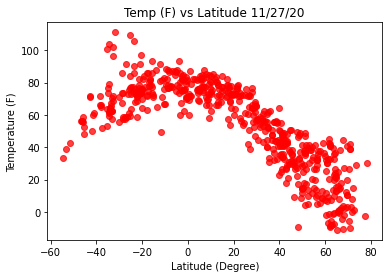

In [8]:
# Create plots with labels
fig, ax = plt.subplots()
ax.scatter(x_axis, cleanWeatherData["Temp"], marker="o", color = "r", alpha = 0.75)
ax.set_xlabel("Latitude (Degree)")
ax.set_ylabel("Temperature (F)")
ax.set_title("Temp (F) vs Latitude 11/27/20")

Text(0.5, 1.0, 'Humidity (%) vs Latitude 11/27/2020')

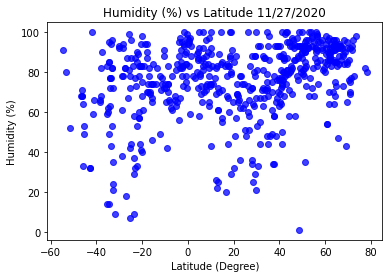

In [9]:
fig, ax = plt.subplots()
ax.scatter(x_axis, cleanWeatherData["Humidity"], marker="o", color = "b", alpha = 0.75)
ax.set_xlabel("Latitude (Degree)")
ax.set_ylabel("Humidity (%)")
ax.set_title("Humidity (%) vs Latitude 11/27/2020")

Text(0.5, 1.0, 'Cloudiness (%) vs Latitude 11/27/2020')

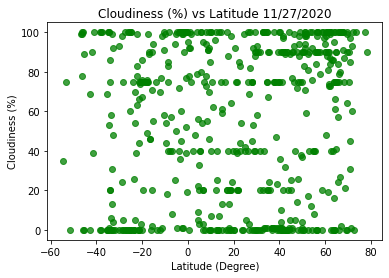

In [10]:
fig, ax = plt.subplots()
ax.scatter(x_axis, cleanWeatherData["Cloudiness"], marker="o", color = "g", alpha = 0.75)
ax.set_xlabel("Latitude (Degree)")
ax.set_ylabel("Cloudiness (%)")
ax.set_title("Cloudiness (%) vs Latitude 11/27/2020")

Text(0.5, 1.0, 'Wind Speed (mph) vs Latitude 11/27/2020')

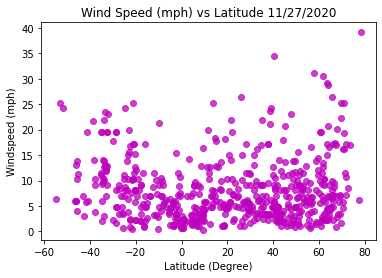

In [11]:
fig, ax = plt.subplots()
ax.scatter(x_axis, cleanWeatherData["Wind Speed"], marker="o", color = "m", alpha = 0.75)
ax.set_xlabel("Latitude (Degree)")
ax.set_ylabel("Windspeed (mph)")
ax.set_title("Wind Speed (mph) vs Latitude 11/27/2020")

## Linear Regression

In [12]:
northWeatherDf = cleanWeatherData[cleanWeatherData["Lat"]>=0]
northWeatherDf.head()

,City,Lat,Lngs,Temp,Humidity,Cloudiness,Wind Speed
4,los llanos de aridane,28.66,-17.92,64.4,63,40,5.82
5,tulum,20.22,-87.47,73.2,85,0,4.61
7,lagoa,39.05,-27.98,54.97,67,23,24.34
8,hilo,19.73,-155.09,72.07,65,40,10.29
10,buchanan,5.88,-10.05,77.41,86,80,3.87


In [13]:
southWeatherDf = cleanWeatherData[cleanWeatherData["Lat"]<0]
southWeatherDf.head()

,City,Lat,Lngs,Temp,Humidity,Cloudiness,Wind Speed
0,castro,-24.79,-50.01,63.37,96,100,8.21
1,bluff,-46.6,168.33,55.99,68,99,5.99
2,busselton,-33.65,115.33,67.35,43,0,13
3,hermanus,-34.42,19.23,61,85,100,14.03
9,kruisfontein,-34,24.73,64,77,86,3


In [14]:
# import package for regression
from scipy.stats import linregress

In [15]:
def linReg(xValues,yValues,xRange):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(xValues.astype(float), yValues.astype(float))
    linEq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    yRange = slope*xRange+intercept
    return linEq, yRange

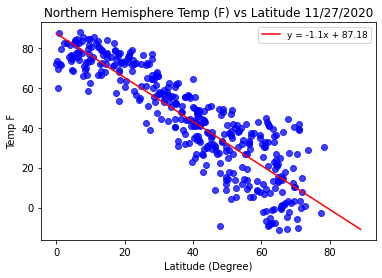

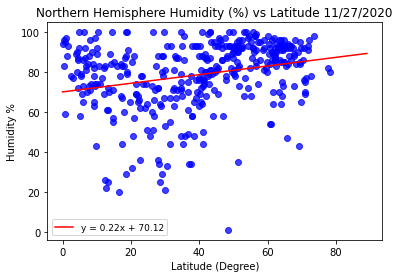

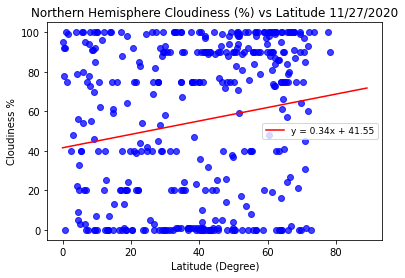

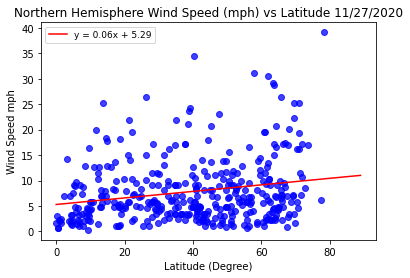

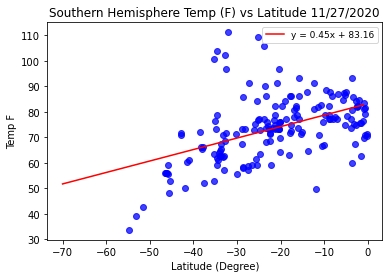

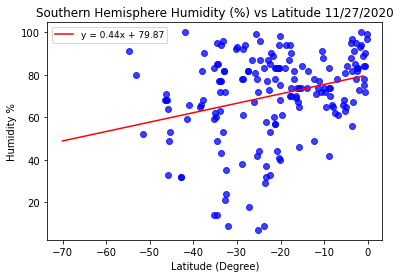

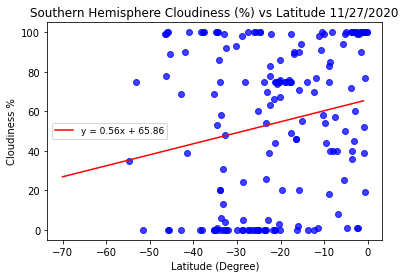

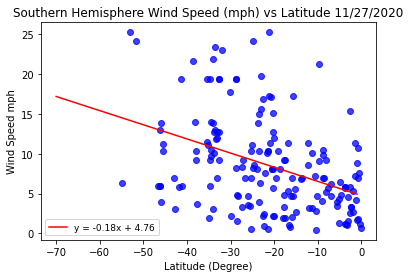

In [16]:
# Plots using for loop:
dfs = [northWeatherDf, southWeatherDf]
dfNames = ["Northern Hemisphere", "Southern Hemisphere"]
xRanges = [range(0, 90, 1), range(-70,0,1)]
yVars = ["Temp","Humidity","Cloudiness","Wind Speed"]
yUnit = ["F","%","%","mph"]

for index in range(len(dfs)):
    df = dfs[index]
    xValues = df["Lat"]
    xRange = xRanges[index]
    dfName = dfNames[index]

    
    for yIndex,yVar in  enumerate(yVars):
        yValues = df[yVar]
        lineEqu, yValuesFitted = linReg(xValues,yValues,xRange)

        fig, ax = plt.subplots()
        ax.scatter(xValues, yValues, marker="o", color = "b", alpha = 0.75)
        ax.plot(xRange, yValuesFitted, 'r', label=lineEqu )
        ax.legend(fontsize=9)
        ax.set_xlabel("Latitude (Degree)")
        ax.set_ylabel(yVar + " " + yUnit[yIndex])
        ax.set_title( dfName + " " + yVar + " (" + yUnit[yIndex] + ") " + "vs Latitude 11/27/2020") 


## Observations: 
* Data collected from Nov 27 at 9pm

* For the plot of Temp vs Lat, cities that are located closer to the equator whose lat is at 0, are often hotter.
* Cities closer to the equators have higher avg temp compared to those who reside further away from the equator.
* (The equator is closer to the sun). Thus we observe the upside down parapola shape, we can conclude there is a 
  - relationship between lat and temp or temp does depend on lat (high Rsquared from linear regression compared to cloudiness or windspeed vs latitude)

* For Humidity vs Lat plot, the cities that are closer to the equators are generally more humid (more clusters of points near the equator) since hot air generally hols more moisture. However, this is a plot of humidity of one day which doesn't generallize any trend because a storm can change level of humidity as well since it affects the flow of hot air and pressure. Thus no clear trend is observed in this plot except near the equator, not a lot of low humidity points.

* For the plot of Cloudiness vs. Lat and Wind Speed vs. Lat, there aren't any observable trends. Data is pretty spread out across the different latitudes. Thus we can conclude based on these plots generally latitudes don't affect the cloudiness or wind speed. (also low R-squared from linear regression plot)

In [18]:
cleanWeatherData.to_csv(r'cities.csv',index=False)